In [1]:
import pandas as pd
from datetime import timedelta, datetime
import seaborn as sns;
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('memberships_usa.csv')
df.shape[0]

1539

In [3]:
#print("Percent of people who pay dues annually: " + str(df[df['membership_type'] == 'annual'].shape[0] / df.shape[0] * 100))
'75%'

'75%'

In [5]:
start = datetime(2016, 1, 1)
end = datetime(2020, 3, 1)
dates = pd.date_range(start, end, freq='MS')
df['join_date'] = pd.to_datetime(df['join_date'])
df['dues_paid_until'] = pd.to_datetime(df['dues_paid_until'])

In [19]:
churn_rates = []
for period_start in dates:
    period_end = period_start + pd.offsets.DateOffset(months=1)
    #print(period_start, period_end)
    
    members_at_period_start = df[(df['join_date'] < period_start) & (df['dues_paid_until'] >= period_start)].shape[0]
    members_joined = df[(df['join_date'] >= period_start) & (df['join_date'] < period_end)].shape[0]
    member_lapsed = df[(df['join_date'] < period_start) & (df['dues_paid_until'] >= period_start) & (df['dues_paid_until'] < period_end)].shape[0]
    churn_rate = member_lapsed/members_at_period_start if members_at_period_start > 0 else 0.0
    aquisition_rate = members_joined/members_at_period_start if members_at_period_start > 0 else 0.0
    
    churn_rates.append((period_start, members_at_period_start, members_joined, member_lapsed, churn_rate, aquisition_rate))

In [43]:
crates = list(map(lambda x: x[4], filter(lambda x: x[0].year > 2017, churn_rates)))
arates = list(map(lambda x: x[5], filter(lambda x: x[0].year > 2017, churn_rates)))
churn_rate = sum(crates) / len(crates)
lifespan = 1 / churn_rate
monthly_ltv = lifespan * 15
annual_ltv = lifespan / 12 * 60
weighted_ltv = annual_ltv * .75 + monthly_ltv * .25
print("Monthly churn rate: " + str(churn_rate))
print("Expected Lifespan (in months): " + str(lifespan))
print("LTV (if paying monthly): " + str(monthly_ltv))
print("LTV (if paying annually): " + str(annual_ltv))
print("LTV (weighted): " + str(weighted_ltv))

Monthly churn rate: 0.041141860922722574
Expected Lifespan (in months): 24.306144096843752
LTV (if paying monthly): 364.5921614526563
LTV (if paying annually): 121.53072048421878
LTV (weighted): 182.29608072632817


In [53]:
members = pd.DataFrame(churn_rates, columns=['Date', 'Members', 'Joined', 'Left', 'Churn Rate', 'Aquisition Rate'])
members[
    (members['Date'] >= pd.Timestamp(2019, 1, 1)) & 
    (members['Date'] <= pd.Timestamp(2019, 12, 1)) &
    (members['Date'] != pd.Timestamp(2019, 6, 1)) &
    (members['Date'] != pd.Timestamp(2019, 7, 1))][['Joined', 'Left']].sum()

members.groupby(members['Date'].dt.year).sum()


Members  Joined  Left  Churn Rate  Aquisition Rate
Date                                                    
2016      859     205     6    0.099180         2.103681
2017     5800     462     9    0.020644         1.120790
2018     8943     502   336    0.456769         0.705448
2019     9862     263   423    0.515026         0.320376
2020     2137      53    99    0.139035         0.074352

In [42]:
plt.figure(figsize=(16, 6))
ax = sns.lineplot(x='Date', y='value', hue='variable', data=pd.melt(members.drop(columns=['Churn Rate', 'Aquisition Rate']), ['Date']))

[(0, 0.3)]

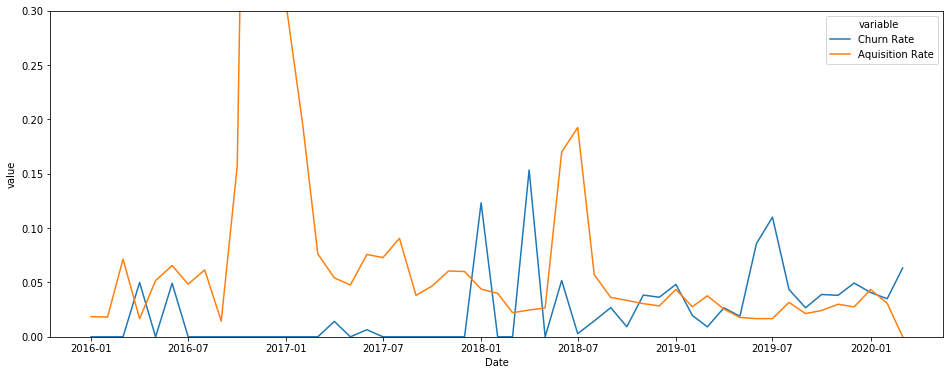

In [33]:
plt.figure(figsize=(16, 6))
ax = sns.lineplot(x='Date', y='value', hue='variable', data=pd.melt(members[['Date', 'Churn Rate', 'Aquisition Rate']], ['Date']))
ax.set(ylim=(0, .3))

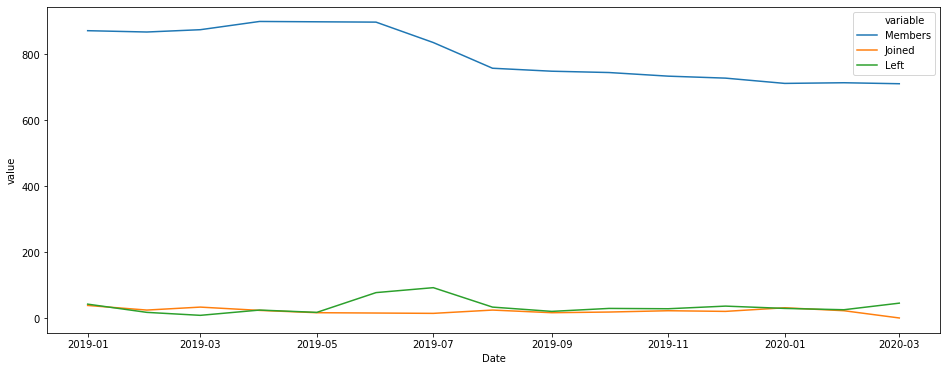

In [10]:
members_2019 = members[members['Date'].dt.year >= 2019]
plt.figure(figsize=(16, 6))
ax = sns.lineplot(x='Date', y='value', hue='variable', data=pd.melt(members_2019, ['Date']))

In [11]:
month_map = {
    1: 'Jan',
    2: "Feb",
    3: "Mar",
    4: "Apr",
    5: "May",
    6: "Jun",
    7: "Jul",
    8: "Aug",
    9: "Sep",
    10: "Oct",
    11: "Nov",
    12: "Dec"
}
monthly_avgs = members[['Joined','Left']].groupby(members['Date'].dt.month).mean()
monthly_avgs.index = monthly_avgs.index.map(month_map)

In [12]:
plt.figure(figsize=(16, 6))
ax = sns.barplot(x='Date', y='value', hue='variable', data=pd.melt(monthly_avgs.reset_index(), ['Date']))

In [13]:
def nyear_retention(num_years, members):
    years = [0, 1, 2, 3, 4, 5]
    total_members = df.shape[0]
    total_retained = []
    for year in years:
        retained = df[(df['dues_paid_until'] > (df['join_date'] + pd.offsets.DateOffset(years=year))) & ((df['join_date'] + pd.offsets.DateOffset(years=year)) < pd.Timestamp(2020, 3, 1))].shape[0]
        eligible = df[(df['join_date'] + pd.offsets.DateOffset(years=year)) < pd.Timestamp(2020, 3, 1)].shape[0]
        total_retained.append((year, retained, eligible, retained/eligible if eligible > 0 else 0))
    return total_retained

In [14]:
def nmonth_retention(num_months, members):
    months = range(num_months)
    bump_retained = []
    for month in months:
        retained = members[(members['dues_paid_until'] > (members['join_date'] + pd.offsets.MonthOffset(month))) & ((members['join_date'] + pd.offsets.MonthOffset(month)) < pd.Timestamp(2020, 3, 1))].shape[0]
        eligible = members[(members['join_date'] + pd.offsets.MonthOffset(month)) < pd.Timestamp(2020, 3, 1)].shape[0]
        bump_retained.append((month, retained, eligible, retained/eligible if eligible > 0 else 0))
    return bump_retained

In [56]:
def retention_curve(df, xlabel, ylabel, num_months):
    plt.figure(figsize=(16, 6))
    plt.ylim(0.0, 1.15)
    ax = sns.lineplot(x=xlabel, y=ylabel, data=df)
    ax.set_xticks(range(1,num_months+1))

In [57]:
full_yearly_retention = pd.DataFrame(map(lambda x: (x[0], x[3]), nyear_retention(60, df)), columns=['Year', 'Percent'])
retention_curve(full_yearly_retention, 'Year', 'Percent', 5)

In [62]:
aoc_bump = df[(df['join_date'] >= pd.Timestamp(2018, 6, 1)) & (df['join_date'] < pd.Timestamp(2018, 8, 1))]
non_aoc = df[(df['join_date'] < pd.Timestamp(2018, 6, 1)) | (df['join_date'] >= pd.Timestamp(2018, 8, 1))]
mems_2016 = df[(df['join_date'] < pd.Timestamp(2017, 1, 1))]
mems_2017 = df[(df['join_date'] >= pd.Timestamp(2017, 1, 1)) & (df['join_date'] < pd.Timestamp(2018, 1, 1))]
mems_2018 = df[(df['join_date'] >= pd.Timestamp(2018, 1, 1)) & (df['join_date'] < pd.Timestamp(2019, 1, 1))]
mems_2019 = df[(df['join_date'] >= pd.Timestamp(2019, 1, 1)) & (df['join_date'] < pd.Timestamp(2020, 1, 1))]

In [92]:
(aoc_bump[aoc_bump['dues_paid_until'] >= pd.Timestamp(2020, 2, 1)].count()[0], aoc_bump.count()[0])

(84, 238)

In [59]:
full_retention = pd.DataFrame(map(lambda x: (x[0], x[3]), nmonth_retention(60, df)), columns=['Month', 'Percent'])
retention_curve(full_retention, 'Month', 'Percent', 60)

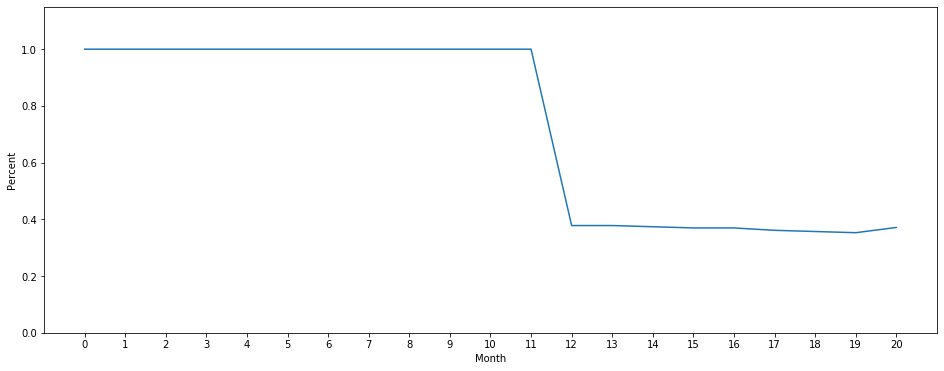

In [289]:
aoc_retention = pd.DataFrame(map(lambda x: (x[0], x[3]), nmonth_retention(21, aoc_bump)), columns=['Month', 'Percent'])
retention_curve(aoc_retention, 'Month', 'Percent', 21)

[(0, 1301, 1301, 1.0),
 (1, 1279, 1279, 1.0),
 (2, 1248, 1248, 1.0),
 (3, 1228, 1228, 1.0),
 (4, 1206, 1206, 1.0),
 (5, 1188, 1188, 1.0),
 (6, 1172, 1172, 1.0),
 (7, 1148, 1148, 1.0),
 (8, 1133, 1134, 0.9991181657848325),
 (9, 1118, 1119, 0.9991063449508489),
 (10, 1102, 1103, 0.99909338168631),
 (11, 1071, 1080, 0.9916666666666667),
 (12, 803, 1047, 0.766953199617956),
 (13, 656, 1023, 0.6412512218963832),
 (14, 564, 985, 0.5725888324873096),
 (15, 502, 960, 0.5229166666666667),
 (16, 486, 933, 0.5209003215434084),
 (17, 477, 904, 0.5276548672566371),
 (18, 452, 873, 0.5177548682703322),
 (19, 434, 826, 0.5254237288135594),
 (20, 433, 826, 0.5242130750605327),
 (21, 432, 826, 0.5230024213075061),
 (22, 422, 810, 0.5209876543209877),
 (23, 406, 793, 0.5119798234552333),
 (24, 393, 778, 0.5051413881748072),
 (25, 365, 752, 0.4853723404255319),
 (26, 332, 721, 0.4604715672676838),
 (27, 305, 681, 0.447870778267254),
 (28, 284, 643, 0.4416796267496112),
 (29, 265, 615, 0.43089430894308944

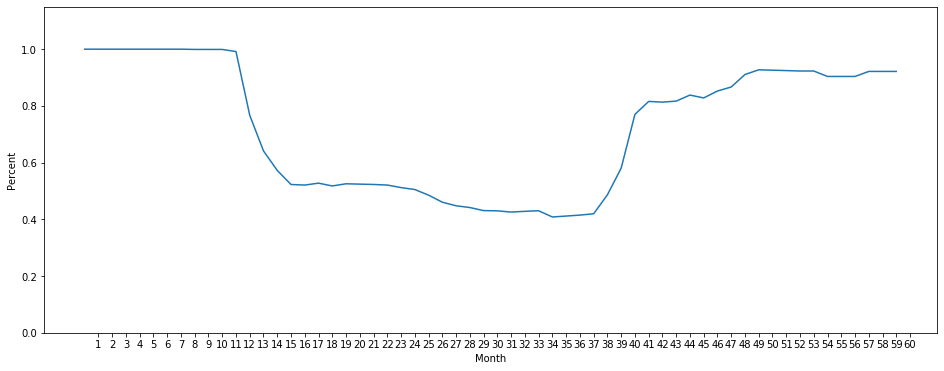

In [60]:
non_aoc_retention = pd.DataFrame(map(lambda x: (x[0], x[3]), nmonth_retention(60, non_aoc)), columns=['Month', 'Percent'])
retention_curve(non_aoc_retention, 'Month', 'Percent', 60)
nmonth_retention(60, non_aoc)

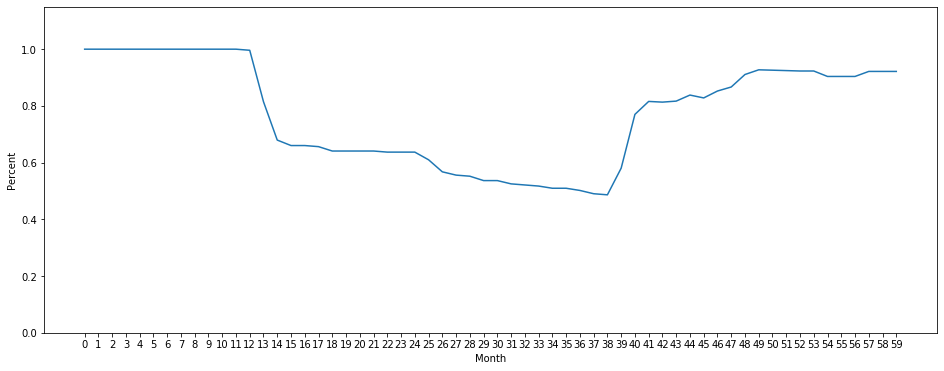

In [308]:
mems_2016_ret = pd.DataFrame(map(lambda x: (x[0], x[3]), nmonth_retention(60, mems_2016)), columns=['Month', 'Percent'])
retention_curve(mems_2016_ret, 'Month', 'Percent', 60)

In [61]:
mems_2017_ret = pd.DataFrame(map(lambda x: (x[0], x[3]), nmonth_retention(37, mems_2017)), columns=['Month', 'Percent'])
retention_curve(mems_2017_ret, 'Month', 'Percent', 37)
nmonth_retention(37, mems_2017)

[(0, 462, 462, 1.0),
 (1, 462, 462, 1.0),
 (2, 462, 462, 1.0),
 (3, 462, 462, 1.0),
 (4, 462, 462, 1.0),
 (5, 462, 462, 1.0),
 (6, 462, 462, 1.0),
 (7, 462, 462, 1.0),
 (8, 462, 462, 1.0),
 (9, 462, 462, 1.0),
 (10, 462, 462, 1.0),
 (11, 454, 462, 0.9826839826839827),
 (12, 396, 462, 0.8571428571428571),
 (13, 310, 462, 0.670995670995671),
 (14, 278, 462, 0.6017316017316018),
 (15, 234, 462, 0.5064935064935064),
 (16, 232, 462, 0.5021645021645021),
 (17, 229, 462, 0.49567099567099565),
 (18, 223, 462, 0.48268398268398266),
 (19, 220, 462, 0.47619047619047616),
 (20, 219, 462, 0.474025974025974),
 (21, 218, 462, 0.47186147186147187),
 (22, 217, 462, 0.4696969696969697),
 (23, 212, 462, 0.4588744588744589),
 (24, 205, 462, 0.44372294372294374),
 (25, 196, 462, 0.42424242424242425),
 (26, 185, 462, 0.4004329004329004),
 (27, 161, 422, 0.3815165876777251),
 (28, 141, 384, 0.3671875),
 (29, 126, 356, 0.3539325842696629),
 (30, 116, 334, 0.3473053892215569),
 (31, 96, 286, 0.3356643356643357

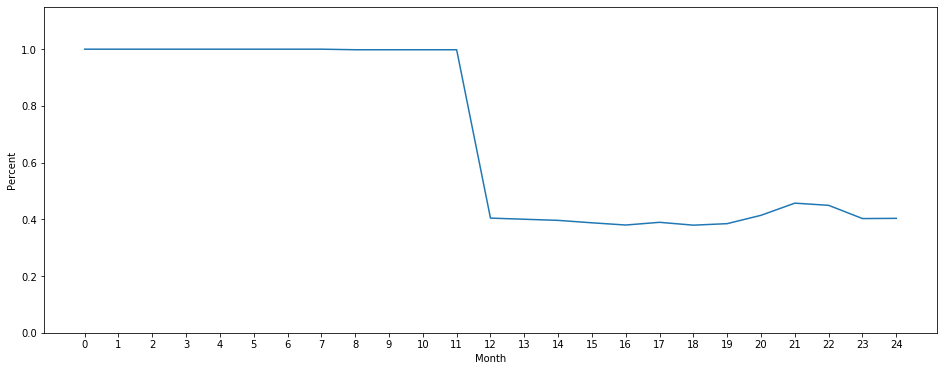

In [298]:
mems_2018_ret = pd.DataFrame(map(lambda x: (x[0], x[3]), nmonth_retention(25, mems_2018)), columns=['Month', 'Percent'])
retention_curve(mems_2018_ret, 'Month', 'Percent', 25)

In [301]:
mems_2019_ret = pd.DataFrame(map(lambda x: (x[0], x[3]), nmonth_retention(14, mems_2019)), columns=['Month', 'Percent'])
retention_curve(mems_2019_ret, 'Month', 'Percent', 14)